# Project 1 Revisited

- Thomas Bingamon

# Import Libraries

In [1]:
#Standard Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## Diagram
from sklearn import set_config
set_config(display='diagram')

## set pandas to display more columns
pd.set_option('display.max_columns',50)

## set to display up to 2 decimal places
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

# Load Data

In [2]:
# Load Data
df= pd.read_csv('Data/sales_predictions.csv')

# Inspect Data

In [3]:
# Display first 5 rows
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


In [4]:
# Display number of rows and columns
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 8523 rows, and 12 columns
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.


# Display Column Names, Count of Non-Null Values, and Data Types

In [5]:
# Display index, columns, null count, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Clean Data

- Check Data Types:

In [6]:
# Display data types
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- Our data has a combination of categorical (object) and numeric (float and int) data types.
- There are no mismatched data types found in our file.

# Check for duplicates

In [7]:
# Display duplicate values
duplicated_values = df.duplicated().sum()

print(f"Total number of duplicate values is {duplicated_values}")

Total number of duplicate values is 0


# Identify missing values

In [8]:
#Display total number of missing values
missing_values= df.isna().sum().sum()
print(f"Total number of missing values is {missing_values}")

Total number of missing values is 3873


In [9]:
# Display the missing values for each column
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
# Display percentage of missing values for each column
df.isna().sum()/len(df) * 100

Item_Identifier              0.00
Item_Weight                 17.17
Item_Fat_Content             0.00
Item_Visibility              0.00
Item_Type                    0.00
Item_MRP                     0.00
Outlet_Identifier            0.00
Outlet_Establishment_Year    0.00
Outlet_Size                 28.28
Outlet_Location_Type         0.00
Outlet_Type                  0.00
Item_Outlet_Sales            0.00
dtype: float64

- will be imputed during preprocessing

# Categorical Columns

- check for inconsistencies in object data type columns.

In [11]:
from scipy.sparse import data
# Create a series of the datatypes
data_types = df.dtypes
# Create a filter to select only the object datatypes
object_data_types = data_types[(data_types == 'object')]
# Display the series of object datatypes
object_data_types

Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

In [12]:
# Display index of object datatypes
object_data_types.index

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [13]:
# Create a Loop through the object datatype columns
for column in object_data_types.index:
    ## Print the column name
    print(column)
    ## Print the unique values from the column
    print(df[column].unique())
    ## Print a blank row
    print('\n')

Item_Identifier
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']


Item_Fat_Content
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


Item_Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


Outlet_Identifier
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


Outlet_Size
['Medium' nan 'High' 'Small']


Outlet_Location_Type
['Tier 1' 'Tier 3' 'Tier 2']


Outlet_Type
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']




## 'Item Fat Content' Column

Fix Inconsistencies in values in Fat Content column:

- LF to Low Fat
- low fat to Low Fat
- reg to Regular

In [14]:
# Display unique values from the column
print(df['Item_Fat_Content'].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


In [15]:
# Display Item Fat Content value counts to look for any inconsistencies
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [16]:
# Replace LF to Low Fat, low fat to Low Fat, reg to Regular in Item Fat Content column
df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace=True)

In [17]:
# Check value counts again to view the changes made
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Numerical Columns

- Check for inconsistencies in all columns that are Integer or Float data types
- Check for unusual or impossible values.
- Check for Outliers

In [18]:
# Display descriptive stats for the numeric columns
df.describe(include= 'number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.00","8,523.00","8,523.00","8,523.00","8,523.00"
mean,12.86,0.07,140.99,"1,997.83","2,181.29"
std,4.64,0.05,62.28,8.37,"1,706.50"
min,4.55,0.00,31.29,"1,985.00",33.29
25%,8.77,0.03,93.83,"1,987.00",834.25
50%,12.60,0.05,143.01,"1,999.00","1,794.33"
75%,16.85,0.09,185.64,"2,004.00","3,101.30"
max,21.35,0.33,266.89,"2,009.00","13,086.96"


- There are no inconsistent values.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Define "X" and target (y)

In [20]:
# Define our Target variable 
X = df.drop(columns = ['Item_Identifier','Outlet_Establishment_Year','Outlet_Identifier','Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

We will remove Item Identifier, Outlet Establishment Year, Outlet Identifier as they are all identifier type columns and not relevant to Item Outlet Sales.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.22,Regular,0.06,Baking Goods,61.25,NaN,Tier 3,Grocery Store
7604,6.13,Low Fat,0.08,Soft Drinks,111.29,Medium,Tier 3,Supermarket Type2
2762,12.15,Low Fat,0.03,Household,151.07,Small,Tier 2,Supermarket Type1
6464,5.95,Low Fat,0.09,Household,127.87,Small,Tier 2,Supermarket Type1
4707,18.20,Regular,0.07,Fruits and Vegetables,247.21,Small,Tier 2,Supermarket Type1


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           7060 non-null   float64
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Size           6113 non-null   object 
 6   Outlet_Location_Type  8523 non-null   object 
 7   Outlet_Type           8523 non-null   object 
dtypes: float64(3), object(5)
memory usage: 532.8+ KB


# Preprocessing & Column Transformer

### Identify each feature as ordinal, numerical, nominal, or pass through

- No ordinal features
- numeric features = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
- nominal features = ['Item_Fat_Content','Item_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type']

# Project 1 Revisited
### Remake X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

In [23]:
# make categorical selector and verify
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [24]:
# make numeric selector and verify
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP']

In [25]:
# make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='median'))

# make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x11e8249d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x11e83ff40>)],
                  verbose_feature_names_out=False)

# Fit on Training data to get column names

In [26]:
# fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Size_High', 'Outlet_Size_MISSING', 'Outlet_Size_Medium',
       'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

## Create a preprocessed DataFrame for our training & Test set

In [27]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.22,0.06,61.25,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
7604,6.13,0.08,111.29,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2762,12.15,0.03,151.07,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
6464,5.95,0.09,127.87,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
4707,18.20,0.07,247.21,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [28]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.25,0.06,132.30,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2391,17.85,0.04,127.10,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
163,7.27,0.07,114.25,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4608,12.55,0.08,145.84,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
5544,13.50,0.12,161.69,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00


In [29]:
# confirm the rows index in y_test matches X_test_df
y_test.head()

8077   1,696.46
2391   2,024.03
163    2,618.59
4608   3,773.75
5544     159.79
Name: Item_Outlet_Sales, dtype: float64

# Create Custom Functions

In [30]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [31]:
# Feature Importance
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [32]:
# Get Coefficients
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

### Functionizing Coefficient Visualization

In [33]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

### Plot Importance

In [34]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [35]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [36]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

# Linear Regression Model

### Fit & Evaluate Model

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1115.77
Test Data:	R^2= 0.56	RMSE= 1164.92


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
# create a linear regression model
model = LinearRegression()

# fit the model to your data
model.fit(X_train_df, y_train)

# make predictions on your test data
y_pred = model.predict(X_test_df)

# calculate the MAE of your model
mae = mae(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 859.918741728941


In [39]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

Outlet_Type_Grocery Store         -1,590.41
Item_Visibility                     -269.51
Outlet_Type_Supermarket Type2       -185.64
intercept                           -137.99
Outlet_Size_MISSING                 -115.21
Item_Type_Soft Drinks               -114.60
Outlet_Location_Type_Tier 1          -87.31
Item_Type_Household                  -68.59
Item_Type_Dairy                      -47.81
Item_Type_Health and Hygiene         -39.34
Outlet_Size_High                     -21.39
Item_Type_Meat                       -16.53
Item_Fat_Content_Low Fat             -15.48
Item_Type_Snack Foods                -10.46
Item_Type_Breads                      -5.47
Item_Type_Frozen Foods                -1.93
Item_Weight                            1.20
Item_Type_Baking Goods                10.23
Item_Fat_Content_Regular              15.48
Item_MRP                              15.60
Item_Type_Others                      16.03
Item_Type_Fruits and Vegetables       16.23
Outlet_Location_Type_Tier 3     

# Visualize Coefficients

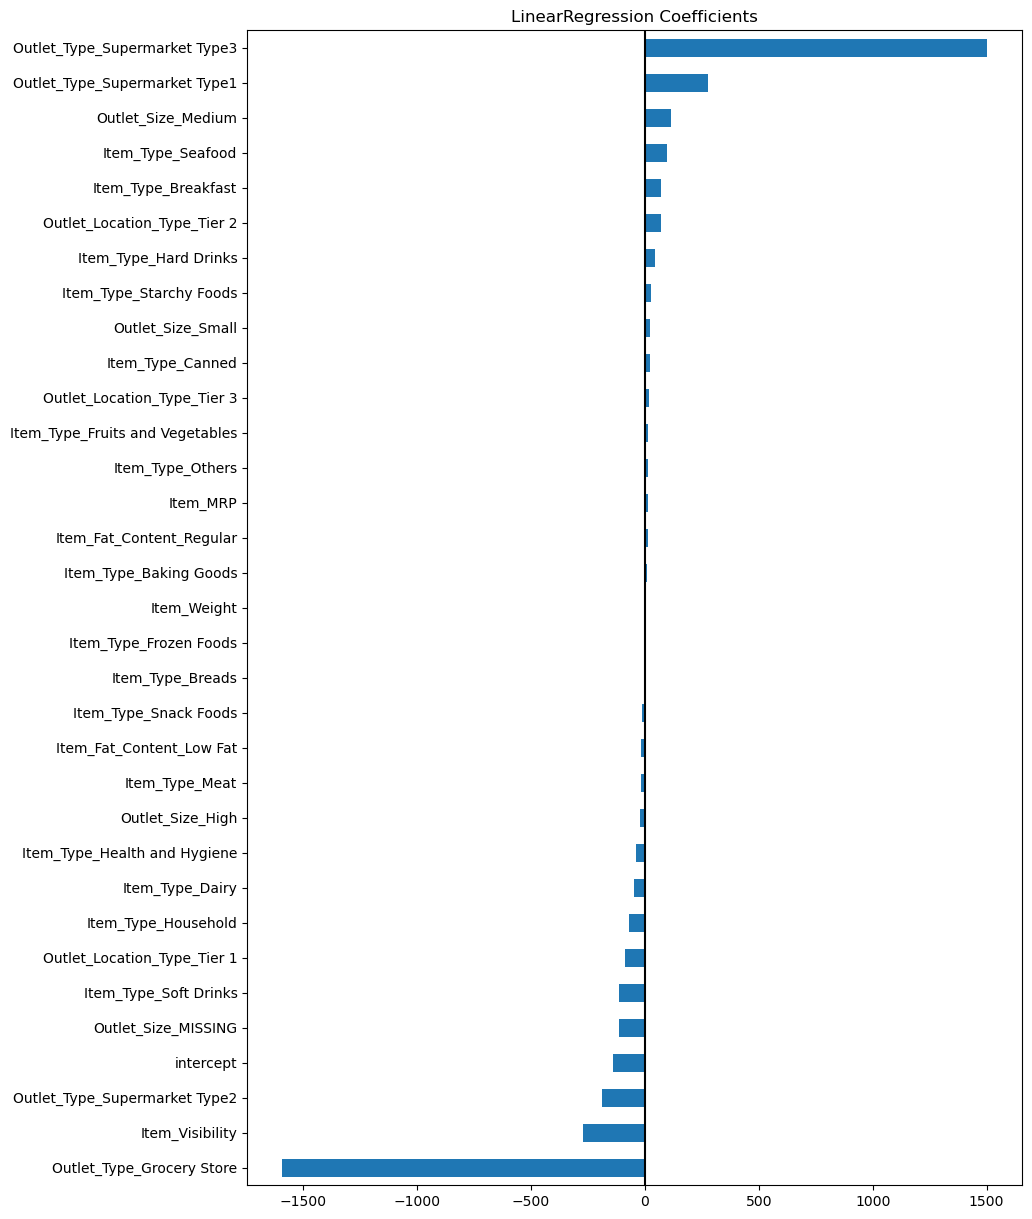

In [40]:
# Plot the coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(10,15))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

# Rank & Order Coefficients

In [41]:
coeff_ranks = coeffs.abs().rank().sort_values(ascending=False)
coeff_ranks

Outlet_Type_Grocery Store         33.00
Outlet_Type_Supermarket Type3     32.00
Outlet_Type_Supermarket Type1     31.00
Item_Visibility                   30.00
Outlet_Type_Supermarket Type2     29.00
intercept                         28.00
Outlet_Size_MISSING               27.00
Item_Type_Soft Drinks             26.00
Outlet_Size_Medium                25.00
Item_Type_Seafood                 24.00
Outlet_Location_Type_Tier 1       23.00
Item_Type_Breakfast               22.00
Outlet_Location_Type_Tier 2       21.00
Item_Type_Household               20.00
Item_Type_Dairy                   19.00
Item_Type_Hard Drinks             18.00
Item_Type_Health and Hygiene      17.00
Item_Type_Starchy Foods           16.00
Outlet_Size_Small                 15.00
Item_Type_Canned                  14.00
Outlet_Size_High                  13.00
Outlet_Location_Type_Tier 3       12.00
Item_Type_Meat                    11.00
Item_Type_Fruits and Vegetables   10.00
Item_Type_Others                   9.00


### Top 3 Coefficients

In [43]:
top_features = coeff_ranks.head(3)
top_features

Outlet_Type_Grocery Store       33.00
Outlet_Type_Supermarket Type3   32.00
Outlet_Type_Supermarket Type1   31.00
dtype: float64

In [44]:
# Slice out the top_n_features names to visualize
plot_vals = coeffs.loc[top_features.index]
plot_vals

Outlet_Type_Grocery Store       -1,590.41
Outlet_Type_Supermarket Type3    1,500.88
Outlet_Type_Supermarket Type1      275.17
dtype: float64

In [45]:
top_n = 3
coeff_ranks = coeffs.abs().rank().sort_values(ascending=False)
top_features = coeff_ranks.head(top_n).index
plot_vals = coeffs.loc[top_features].sort_values()
plot_vals

Outlet_Type_Grocery Store       -1,590.41
Outlet_Type_Supermarket Type1      275.17
Outlet_Type_Supermarket Type3    1,500.88
dtype: float64

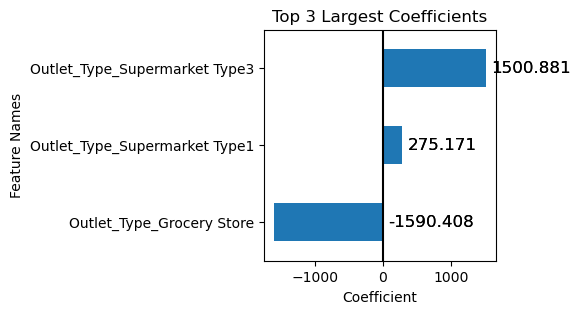

In [46]:
fig, ax = plt.subplots()
ax = plot_coeffs(coeffs,top_n=3,annotate=True, figsize=(3,3));
annotate_hbars(ax)

# Interpret The Model's Coefficients

- Intercept:

 -- Our model assumed a baseline Item Outlet Sales of -137.99


- Outlet_Type_Grocery Store:

  -- If the item sold belongs to this category, the Item_Outlet_Sales will be decreased by 1590.41.


- Outlet_Type_Supermarket Type 3:

  -- If the item sold belongs to this category, the 
  Item Outlet Sales increases by 1500.88


- Outlet_Type_Supermarket Type 1: 

  -- If the item sold belongs to this category, the Item Outlet Sales increases Item Outlet Sales by 275.17

### Save Image as .PNG

In [47]:
import os
os.makedirs("Images/", exist_ok=True)

In [48]:
fig.savefig('Images/linear_regression_top3_coefficients.png', bbox_inches='tight')

# Random Forest Model

In [49]:
# fit random forest
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)
## Saving the feature importances
importances = get_importances(reg)

Training Data:	R^2= 0.94	RMSE= 429.41
Test Data:	R^2= 0.55	RMSE= 1175.42


In [50]:
# Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
sorted_importance

Item_Type_Seafood                 0.00
Item_Type_Others                  0.00
Item_Type_Breakfast               0.00
Outlet_Type_Supermarket Type2     0.00
Item_Type_Breads                  0.00
Item_Type_Hard Drinks             0.00
Item_Type_Starchy Foods           0.00
Outlet_Type_Supermarket Type1     0.00
Item_Type_Meat                    0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Soft Drinks             0.00
Outlet_Size_High                  0.00
Item_Type_Canned                  0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Baking Goods            0.00
Item_Fat_Content_Low Fat          0.00
Item_Fat_Content_Regular          0.00
Outlet_Size_Medium                0.01
Item_Type_Dairy                   0.01
Outlet_Location_Type_Tier 2       0.01
Item_Type_Frozen Foods            0.01
Outlet_Location_Type_Tier 1       0.01
Item_Type_Household               0.01
Outlet_Size_MISSING               0.01
Outlet_Size_Small                 0.01
Item_Type_Snack Foods    

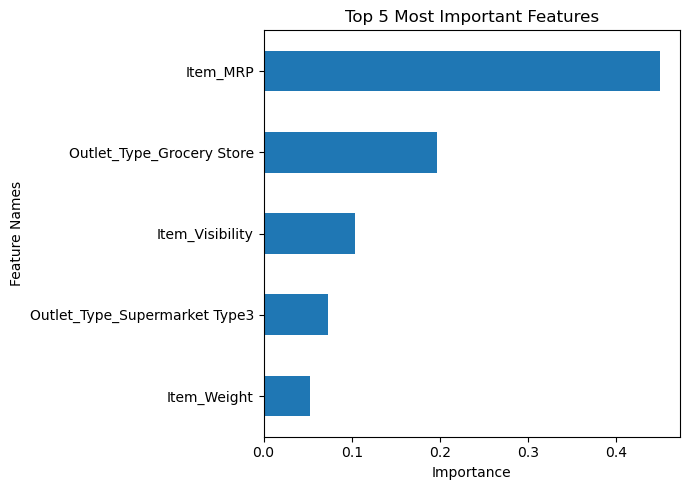

In [51]:
# plot top 5 importances
fig, ax = plt.subplots()
ax = sorted_importance.tail(5).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 5 Most Important Features');
plt.tight_layout()

In [52]:
# Save image as png
fig.savefig('Images/default_random_forest_top5_important_features.png', bbox_inches='tight')

In [53]:
reg.feature_importances_

array([0.05286186, 0.10313887, 0.44991848, 0.00474356, 0.00486818,
       0.00455905, 0.00294898, 0.00242571, 0.00430419, 0.00555535,
       0.00574475, 0.00819696, 0.00295156, 0.00440802, 0.00625843,
       0.0036274 , 0.00161815, 0.00143331, 0.00812727, 0.0041229 ,
       0.00301043, 0.00413855, 0.00630588, 0.00537833, 0.00812637,
       0.00587009, 0.0056781 , 0.00411995, 0.19675819, 0.00334503,
       0.00259953, 0.07285654])

In [54]:
# Check the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

32
32


True

In [55]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')

## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
sorted_importance

Item_Type_Seafood                 0.00
Item_Type_Others                  0.00
Item_Type_Breakfast               0.00
Outlet_Type_Supermarket Type2     0.00
Item_Type_Breads                  0.00
Item_Type_Hard Drinks             0.00
Item_Type_Starchy Foods           0.00
Outlet_Type_Supermarket Type1     0.00
Item_Type_Meat                    0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Soft Drinks             0.00
Outlet_Size_High                  0.00
Item_Type_Canned                  0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Baking Goods            0.00
Item_Fat_Content_Low Fat          0.00
Item_Fat_Content_Regular          0.00
Outlet_Size_Medium                0.01
Item_Type_Dairy                   0.01
Outlet_Location_Type_Tier 2       0.01
Item_Type_Frozen Foods            0.01
Outlet_Location_Type_Tier 1       0.01
Item_Type_Household               0.01
Outlet_Size_MISSING               0.01
Outlet_Size_Small                 0.01
Item_Type_Snack Foods    

## Top 5 Most Important Features

In [56]:
importances.sort_values(ascending=False).head(5)

Item_MRP                        0.45
Outlet_Type_Grocery Store       0.20
Item_Visibility                 0.10
Outlet_Type_Supermarket Type3   0.07
Item_Weight                     0.05
Name: Feature Importance, dtype: float64

In [57]:
plot_train = pd.concat([X_train_df,y_train],axis=1)
plot_test = pd.concat([X_test_df,y_test],axis=1)
plot_df = pd.concat([plot_train, plot_test])
plot_df

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
8269,7.22,0.06,61.25,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,126.50
7604,6.13,0.08,111.29,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,"2,263.72"
2762,12.15,0.03,151.07,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,"2,858.95"
6464,5.95,0.09,127.87,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,"2,195.81"
4707,18.20,0.07,247.21,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,"3,486.13"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,12.85,0.03,172.44,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,"4,483.50"
5323,17.25,0.04,163.75,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,"3,289.05"
22,14.60,0.03,196.51,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,"1,587.27"
4526,13.85,0.03,114.25,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,"1,853.59"


<AxesSubplot: xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

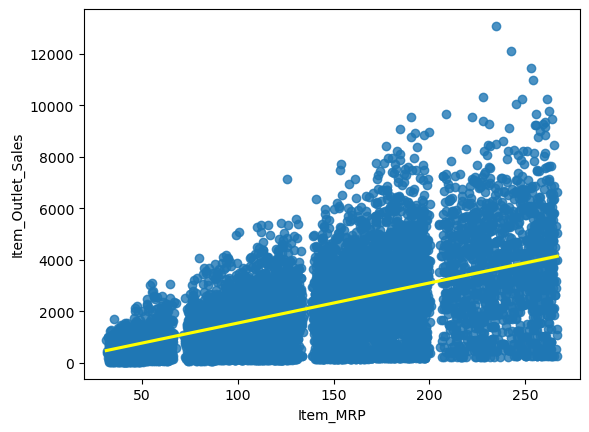

In [63]:
sns.regplot(data=plot_df, x='Item_MRP',y='Item_Outlet_Sales', line_kws={'color': 'yellow'})

<AxesSubplot: xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

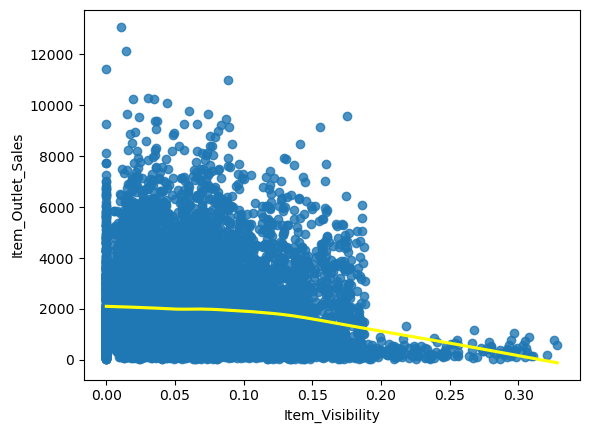

In [62]:
sns.regplot(data=plot_df, x='Item_Visibility',y='Item_Outlet_Sales', lowess=True, line_kws={'color': 'yellow'})

<AxesSubplot: xlabel='Outlet_Type_Supermarket Type3', ylabel='Item_Outlet_Sales'>

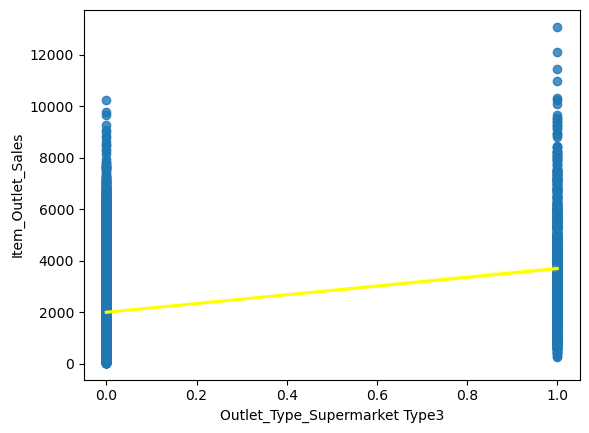

In [64]:
sns.regplot(data=plot_df, x='Outlet_Type_Supermarket Type3',y='Item_Outlet_Sales', line_kws={'color': 'yellow'})

<AxesSubplot: xlabel='Item_Weight', ylabel='Item_Outlet_Sales'>

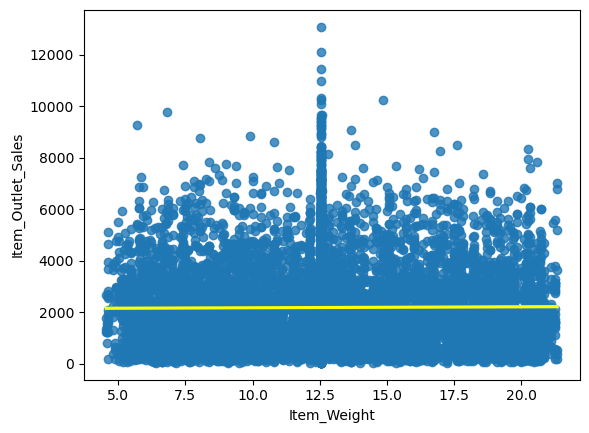

In [65]:
sns.regplot(data=plot_df, x='Item_Weight',y='Item_Outlet_Sales', line_kws={'color': 'yellow'})

# Serialize Best Models with Joblib

In [66]:
## saving variables
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
         'y_test': y_test,
         'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
         'RandomForest': reg}
joblib.dump(export, 'regression_models.joblib')

['regression_models.joblib']